<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
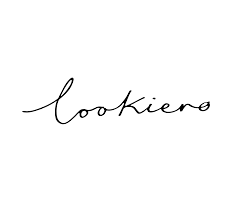    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Link prediction
Se generan multiples redes prediciendo los edges

In [ ]:
import pandas as pd
import numpy as np
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [ ]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when

- **Strings**

In [ ]:
from collections import Counter

- **Visualización**

In [ ]:
import matplotlib.pyplot as plt

* **Grafos**

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges

- **Otros**

In [ ]:
import itertools

## Funciones a utilizar
---

In [ ]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [ ]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [ ]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [ ]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

In [ ]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

### Embeddings
---

In [ ]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

In [ ]:
from node2vec import Node2Vec
import gensim
gensim.__version__

'4.1.2'

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
from torch_geometric.utils import negative_sampling
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

* Se genera el modelo para hacer el embedding

In [ ]:
node2vec = Node2Vec(G7, dimensions=64, walk_length=10, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
t10cu_emb = { n: list(map(float,model.wv.get_vector(n))) for n in G7.nodes()}

* Se incluye el embedding en el nodo

In [ ]:
for x, v  in t10cu_emb.items(): G7.nodes[x]['x'] = v

* Embedding manual, es simplemente un one hot enocodding

In [ ]:
for v in ['color','size','level']:
    attr = [G7.nodes[x][v] for x in G7.nodes()]

    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(attr)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    guardar_pikle(onehot_encoded, 'onehot_encoded_' + v)

In [ ]:
color, size, level = abrir_pikle('onehot_encoded_color'), abrir_pikle('onehot_encoded_size'), abrir_pikle('onehot_encoded_level')
encoding = np.concatenate((color, size, level), axis=1)

for k, v in enumerate(encoding.tolist()): G7.nodes[k]['x_encoded'] = v

* Otro ejemplo de embedding que **no va tan bien**

In [ ]:
from AnonymousWalkKernel import AnonymousWalks

aw = AnonymousWalks(G7)
length = 3 # length of the walks

aw._all_paths(steps=length)
print('All possible anonymous walks of length {} (a.k.a embedding size)'.format(length))
print(aw.paths[length])

* Se pasa a formato de pytorch y se divide en train test los edges

In [ ]:
from torch_geometric.utils import to_networkx, from_networkx, train_test_split_edges
G7_torch = from_networkx(G7)
print(G7_torch)
G7_torch = train_test_split_edges(G7_torch)
print(G7_torch)

Data(edge_index=[2, 232104], color=[2079], size=[2079], level=[2079], x_encoded=[2079, 50], weight=[232104], num_nodes=2079)
Data(color=[2079], size=[2079], level=[2079], x_encoded=[2079, 50], weight=[232104], num_nodes=2079, val_pos_edge_index=[2, 5802], test_pos_edge_index=[2, 11605], train_pos_edge_index=[2, 197290], train_neg_adj_mask=[2079, 2079], val_neg_edge_index=[2, 5802], test_neg_edge_index=[2, 11605])


In [ ]:
print(G7_torch.val_neg_edge_index)
[x for x in G7.edges() if x == (970, 2068)]

tensor([[ 486,  104, 2004,  ..., 1193,  556,   87],
        [1985, 1600, 2054,  ..., 1631,  631,   99]])


[]

In [ ]:
training_index = set(np.array(torch.unique(G7_torch.train_pos_edge_index)))
nodes = set([x for x in G7.nodes()])
test_nodes = list(nodes - training_index)

In [ ]:
197290 + 5802 + 11605 + 11605 + 5802 == 232104

True

* Se genera una red de prueba

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(np.shape(G7_torch.x_encoded)[1], 32)
        self.conv2 = GCNConv(32, 16)

    def encode(self):
        x = self.conv1(G7_torch.x_encoded, G7_torch.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, G7_torch.train_pos_edge_index) # convolution 2
        
    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product 
        return logits

    def decode_all(self, z): 
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list 

In [ ]:
model, data = Net(), G7_torch
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

* Se generan las funciones de entrenamiento y de testeo

In [ ]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equal to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode
    
    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid
        
        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link

        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs


In [ ]:
best_val_perf = test_perf = 0
for epoch in range(1, 61):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))

Epoch: 010, Loss: 0.4580, Val: 0.9879, Test: 0.9880
Epoch: 020, Loss: 0.4111, Val: 0.9879, Test: 0.9880
Epoch: 030, Loss: 0.4025, Val: 0.9879, Test: 0.9880
Epoch: 040, Loss: 0.4008, Val: 0.9879, Test: 0.9880
Epoch: 050, Loss: 0.3996, Val: 0.9879, Test: 0.9880
Epoch: 060, Loss: 0.4014, Val: 0.9879, Test: 0.9880


In [ ]:
z = model.encode()
final_edge_index = model.decode_all(z)

In [ ]:
print(np.shape(z),np.shape(final_edge_index))
z, final_edge_index

torch.Size([2079, 16]) torch.Size([2, 4157579])


(tensor([[-0.0121, -0.2469,  0.1043,  ..., -0.0589,  0.1427, -0.0432],
         [-0.0224, -0.0668, -0.0039,  ...,  0.0736,  0.1232,  0.1165],
         [ 0.2553, -0.3356,  0.2258,  ..., -0.2967, -0.1108,  0.0763],
         ...,
         [ 0.0214, -0.0549,  0.2124,  ..., -0.2616, -0.3166, -0.1025],
         [-0.0227, -0.0676, -0.0037,  ...,  0.0742,  0.1243,  0.1176],
         [-0.1550, -0.2558,  0.0857,  ...,  0.1298, -0.0690, -0.2096]],
        grad_fn=<AddBackward0>),
 tensor([[   0,    0,    0,  ..., 2078, 2078, 2078],
         [   0,    1,    2,  ..., 2076, 2077, 2078]]))

In [ ]:
prediction_list = (np.array(final_edge_index)).tolist()
links_finales = np.array([x for x in prediction_list if x[0] in (test_nodes) ])